<h1>Business Problem</h1>

Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.In this Project our task is to predict whether a question asked on Quora is sincere or not.<br>

Some Characteristics of the questions being insincere
<ul>
    <li>Has a non-neutral tone</li>
    <li>Isn't grounded in reality</li>
    <li>Is disparaging or inflammatory</li>
    <li>Uses sexual content (incest, bestiality, pedophilia) for shock value, and not to seek genuine answers</li>


<h1>Business Constraints</h1>

1.No Low Latency requirement<br>
2.It would be good if the model can output the probabilities for each class i.e Some form of Interpretability<br>
3.Precision and Recall should be high.Because if the question is insincere than the model should accurately predict the class label as insincere.

<h1>Project Scope</h1>

To date, Quora has employed both machine learning and manual review to address this problem. With the help of this project, they can develop more scalable methods to detect toxic and misleading content.The project can help Quora uphold their policy of “Be Nice, Be Respectful” and continue to be a place for sharing and growing the world’s knowledge.

<h1>Performance Metrics</h1>

This project uses the F1 score as a performance metric which balances precision and recall.

Precision is the number of true positives divided by all positive predictions. Precision is also called Positive Predictive Value. It is a measure of a classifier's exactness. Low precision indicates a high number of false positives.<br>
Recall is the number of true positives divided by the number of positive values in the test data. Recall is also called Sensitivity or the True Positive Rate. It is a measure of a classifier's completeness. Low recall indicates a high number of false negatives.

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from nltk.tokenize import word_tokenize, sent_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer 

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

from wordcloud import WordCloud

In [6]:
#Loading the Dataset 
quora_data=pd.read_csv('Train Data/train.csv')
quora_data.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [7]:
#Number of Questions
print("Total Number of questions in the dataset are {0} ".format(quora_data.shape[0]))

Total Number of questions in the dataset are 1306122 


In [8]:
#Features
print(quora_data.columns)

Index(['qid', 'question_text', 'target'], dtype='object')


qid - unique question identifier<br>
question_text - Quora question text<br>
target - a question labeled "insincere" has a value of 1, otherwise 0

In [9]:
quora_data.loc[quora_data['target']==0].head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [10]:
quora_data.loc[quora_data['target']==0].tail()

,qid,question_text,target
1306117,ffffcc4e2331aaf1e41e,What other technical skills do you need as a c...,0
1306118,ffffd431801e5a2f4861,Does MS in ECE have good job prospects in USA ...,0
1306119,ffffd48fb36b63db010c,Is foam insulation toxic?,0
1306120,ffffec519fa37cf60c78,How can one start a research project based on ...,0
1306121,ffffed09fedb5088744a,Who wins in a battle between a Wolverine and a...,0


In [11]:
#Analyzing some sincere questions
print(quora_data.iloc[1306117]['question_text'])
print('='*50)

print(quora_data.iloc[1306118]['question_text'])
print('='*50)

print(quora_data.iloc[1306121]['question_text'])
print('='*50)

print(quora_data.iloc[1306120]['question_text'])
print('='*50)

print(quora_data.iloc[2]['question_text'])
print('='*50)

print(quora_data.iloc[1]['question_text'])
print('='*50)

What other technical skills do you need as a computer science undergrad other than c and c++?
Does MS in ECE have good job prospects in USA or like India there are more IT jobs present?
Who wins in a battle between a Wolverine and a Puma?
How can one start a research project based on biochemistry at UG level?
Why does velocity affect time? Does velocity affect space geometry?
Do you have an adopted dog, how would you encourage people to adopt and not shop?


In [12]:
#Top 5 Data Points with insincere question 
quora_data.loc[quora_data['target']==1].head(3)

,qid,question_text,target
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1


In [13]:
quora_data.loc[quora_data['target']==1].tail()

,qid,question_text,target
1306093,fffeba722d9b371bd1b9,How is it to have intimate relation with your ...,1
1306094,fffee269360dd0d3947a,Why is it when singers have lyrics about voice...,1
1306099,ffff0e4ea1bb6e16feec,Do pakis smell of curry and shit?,1
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306112,ffffa5b0fa76431c063f,Are you ashamed of being an Indian?,1


In [14]:
#Analyzing some unsincere questions asked by people on quora
print(quora_data.iloc[114]['question_text'])
print('='*50)

print(quora_data.iloc[30]['question_text'])
print('='*50)

print(quora_data.iloc[1306112]['question_text'])
print('='*50)

print(quora_data.iloc[1306093]['question_text'])
print('='*50)

print(quora_data.iloc[1306103]['question_text'])
print('='*50)

I am gay boy and I love my cousin (boy). He is sexy, but I dont know what to do. He is hot, and I want to see his di**. What should I do?
Which babies are more sweeter to their parents? Dark skin babies or light skin babies?
Are you ashamed of being an Indian?
How is it to have intimate relation with your cousin?
Isn't Trump right after all? Why should the USA be benevolent towards it's neighbor Mexico, and not put America first, when Russia is invading Ukraine? Even India imposed a blockade over Nepal after an earthquake?


In [15]:
#Calculating the total number of unique questions
print("Total Number of Unique questions are {0}".format(len(quora_data['qid'].unique())))

Total Number of Unique questions are 1306122


So all the questions are unique and no question is repeated in the dataset

In [16]:
unsincere_questions=quora_data.loc[quora_data['target']==1]['question_text']
sincere_questions=quora_data.loc[quora_data['target']==0]['question_text']

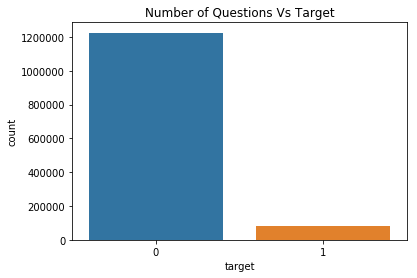

In [17]:
#Analysis on Class Label
sns.countplot(x='target',data=quora_data)
plt.title('Number of Questions Vs Target')
plt.show()

Number of sincere questions are much more in number as compared to insincere questions

In [18]:
#Finding the Percentage of Sincere and Insincere questions
print("Sincere questions consitute about {0}% of all questions in the dataset".format((quora_data['target'].value_counts()[0])/len(quora_data)*100))
print("Insincere questions consitute about {0}% of all questions in the dataset".format((quora_data['target'].value_counts()[1])/len(quora_data)*100))

Sincere questions consitute about 93.81298224821265% of all questions in the dataset
Insincere questions consitute about 6.187017751787352% of all questions in the dataset


So there more than 93% of the questions which are sincere.This indicates that the datset is highly imbalanced

In [19]:
#Checking for nan values
print(quora_data['question_text'].isnull().sum())
print(quora_data['target'].isnull().sum())
print(quora_data['qid'].isnull().sum())

0
0
0


So there are no null values or empty rows in the dataset.

In [20]:
#Checking for duplicated data
quora_data.duplicated(subset={"question_text","qid","target"}).value_counts()

False    1306122
dtype: int64

There are no duplicate rows or questions in the dataset.

In [21]:
#Length of Question
len_ques=[]
for question in quora_data['question_text'].values:
    len_ques.append(len(question))

In [22]:
quora_data['Length']=len_ques  #Adding Length of question as a feature

In [23]:
quora_data.head()

,qid,question_text,target,Length
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,72
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,81
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,67
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,57
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,77


In [24]:
#Number of Words in question
words_ques=[]
for question in quora_data['question_text'].values:
    words_ques.append(len(question.split(" ")))

In [25]:
quora_data['Total_Words']=words_ques
quora_data.head()

,qid,question_text,target,Length,Total_Words
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,72,13
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,81,16
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,67,10
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,57,9
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,77,15


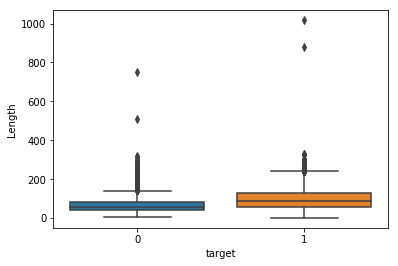

In [26]:
#Performing Univariate Analysis on Length
sns.boxplot(y='Length',x='target',data=quora_data)
plt.show()

1.There are some insincere questions having more length as compared to sincere questions.<br>
2.25th Percentile and 50th percentile values for sincere questions are nearly same.<br>
3.Length can be considered a good feature here as the box plots for both the classes are not completly overlapping.There is some variation seen.But it is important to note Length cannot explained the insincerity of the question

In [27]:
print("The Maximum Length of question is {0}".format(quora_data['Length'].max()))

The Maximum Length of question is 1017


In [28]:
print(quora_data.loc[quora_data['Length']==1017]['question_text']) #Question with maximum Length

443216    What is [math]\frac{\int_{1x^5}^{3x^{-5}} \tan...
Name: question_text, dtype: object


It seems like someone has asked the question abt math and more interestingly the question was marked as insincere

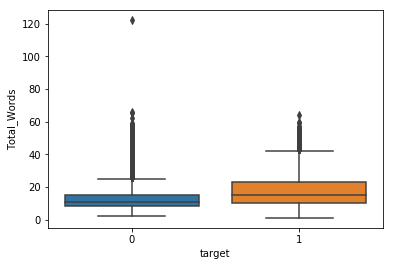

In [29]:
#Performing univariate Analysis on Total_Words
sns.boxplot(y='Total_Words',x='target',data=quora_data)
plt.show()

1.Number of words for insincere questions are more as compared to sincere questions.

In [30]:
#Counting total stopwords
from nltk.corpus import stopwords

stop_words=[]
stopwords = set(stopwords.words('english'))

for question in quora_data['question_text'].values:
    words=question.split(" ")
    count=0
    for word in words:
        if word in stopwords:
            count=count+1
    stop_words.append(count)

In [31]:
quora_data['Total_stopwords']=stop_words

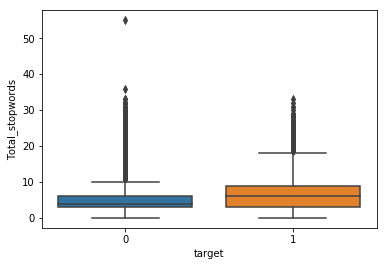

In [32]:
#Performing univariate Analysis on stop_words
sns.boxplot(y='Total_stopwords',x='target',data=quora_data)
plt.show()

1.No. of stopwords are more in insincere questions than sincere questions

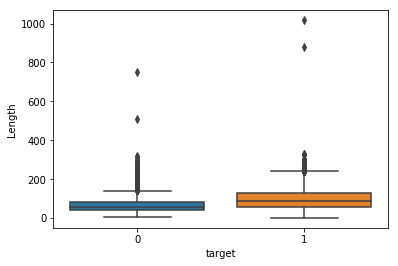

In [33]:
#Performing univariate Analysis on Total_Words
sns.boxplot(y='Length',x='target',data=quora_data)
plt.show()

1.The length of the insincere questions are more than sincere questions

In [34]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [26]:
import string
quora_data["punctuations_count"] =quora_data['question_text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))

In [35]:
uppercase_alphabets=list(string.ascii_lowercase[:26])
quora_data['uppercase_count']=quora_data['question_text'].apply(lambda x:len([c for c in str(x) if c in uppercase_alphabets]))

In [36]:
quora_data['num_exclamation_marks'] = quora_data['question_text'].apply(lambda comment: comment.count('!'))

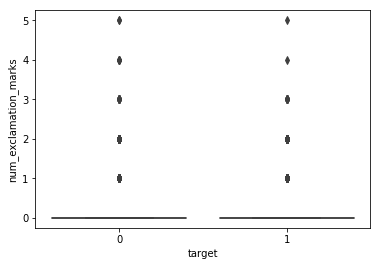

In [37]:
sns.boxplot(y='num_exclamation_marks',x='target',data=quora_data)
plt.show()

1.Number of Exclamantion marks for most of the questions is zero but there are some questions where count of exclamation marks is greater than 0.

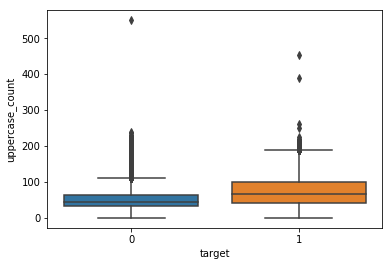

In [38]:
sns.boxplot(y='uppercase_count',x='target',data=quora_data)
plt.show()

1.No. of punctuations for insincere questions are higher in number as compared to sincere questions

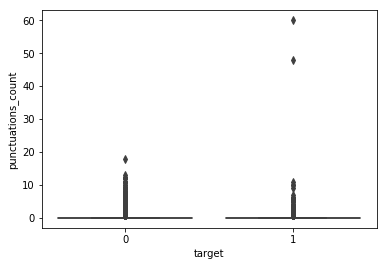

In [79]:
sns.boxplot(y='punctuations_count',x='target',data=quora_data)
plt.show()

C:\Users\om\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


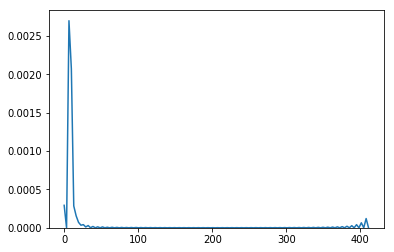

In [31]:
sns.kdeplot(np.array(quora_data['punctuations_count']))
plt.show()

1.Punctutation Count for both the type of questions are roughly the same,so this may not help for classifying whether a question is sincere or insincere<br>
2.A very skewed distribution of punctuations_count is seen

<h1>Data Cleaning</h1>

In [34]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [42]:
sent = decontracted(quora_data['question_text'].values[20000])
print(sent)
print("="*50)

I never talk to people. I often can not hear nor comprehend other is speech in my dreams. Why is so?


In [36]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

Do you know anyone from LNMIIT who has given SSC exam and succeeded?


In [37]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent) #removing Special characters
print(sent)

Do you know anyone from LNMIIT who has given SSC exam and succeeded 


In [38]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [47]:
import re

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

In [48]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_questions = []
# tqdm is for printing the status bar
for sentance in tqdm(quora_data['question_text'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent=cleanhtml(sent);
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_questions.append(sent.lower().strip())

100%|██████████████████████████████████████████████████████████████████████| 1306122/1306122 [02:13<00:00, 9817.70it/s]


In [50]:
import pickle
pickle.dump(preprocessed_questions,open('preprocessed_questions.p','wb'))

In [60]:
#After preprocessing
print(preprocessed_questions[20])
print(quora_data['question_text'].values[20])

how i know whether girl done sex sex
How I know whether a girl had done sex before sex with me?


In [13]:
import pickle
pre_essays=pickle.load(open('preprocessed_questions.p','rb'))

In [18]:
rare_words_mapping = {' s.p ': ' ', ' S.P ': ' ', 'U.s.p': '', 'U.S.A.': 'USA', 'u.s.a.': 'USA', 'U.S.A': 'USA',
                      'u.s.a': 'USA', 'U.S.': 'USA', 'u.s.': 'USA', ' U.S ': ' USA ', ' u.s ': ' USA ', 'U.s.': 'USA',
                      ' U.s ': 'USA', ' u.S ': ' USA ', 'fu.k': 'fuck', 'U.K.': 'UK', ' u.k ': ' UK ',
                      ' don t ': ' do not ', 'bacteries': 'batteries', ' yr old ': ' years old ', 'Ph.D': 'PhD',
                      'cau.sing': 'causing', 'Kim Jong-Un': 'The president of North Korea', 'savegely': 'savagely',
                      'Ra apist': 'Rapist', '2fifth': 'twenty fifth', '2third': 'twenty third',
                      '2nineth': 'twenty nineth', '2fourth': 'twenty fourth', '#metoo': 'MeToo',
                      'Trumpcare': 'Trump health care system', '4fifth': 'forty fifth', 'Remainers': 'remainder',
                      'Terroristan': 'terrorist', 'antibrahmin': 'anti brahmin',
                      'fuckboys': 'fuckboy', 'Fuckboys': 'fuckboy', 'Fuckboy': 'fuckboy', 'fuckgirls': 'fuck girls',
                      'fuckgirl': 'fuck girl', 'Trumpsters': 'Trump supporters', '4sixth': 'forty sixth',
                      'culturr': 'culture',
                      'weatern': 'western', '4fourth': 'forty fourth', 'emiratis': 'emirates', 'trumpers': 'Trumpster',
                      'indans': 'indians', 'mastuburate': 'masturbate', 'f**k': 'fuck', 'F**k': 'fuck', 'F**K': 'fuck',
                      ' u r ': ' you are ', ' u ': ' you ', '操你妈': 'fuck your mother', 'e.g.': 'for example',
                      'i.e.': 'in other words', '...': '.', 'et.al': 'elsewhere', 'anti-Semitic': 'anti-semitic',
                      'f***': 'fuck', 'f**': 'fuc', 'F***': 'fuck', 'F**': 'fuc',
                      'a****': 'assho', 'a**': 'ass', 'h***': 'hole', 'A****': 'assho', 'A**': 'ass', 'H***': 'hole',
                      's***': 'shit', 's**': 'shi', 'S***': 'shit', 'S**': 'shi', 'Sh**': 'shit',
                      'p****': 'pussy', 'p*ssy': 'pussy', 'P****': 'pussy',
                      'p***': 'porn', 'p*rn': 'porn', 'P***': 'porn',
                      'st*up*id': 'stupid',
                      'd***': 'dick', 'di**': 'dick', 'h*ck': 'hack',
                      'b*tch': 'bitch', 'bi*ch': 'bitch', 'bit*h': 'bitch', 'bitc*': 'bitch', 'b****': 'bitch',
                      'b***': 'bitc', 'b**': 'bit', 'b*ll': 'bull'
                      }


def pre_clean_rare_words(text):
    for rare_word in rare_words_mapping:
        if rare_word in text:
            text = text.replace(rare_word, rare_words_mapping[rare_word])

    return text

In [ ]:
quora_data['pre_essays']=pre_essays

In [45]:
quora_data.head()

,qid,question_text,target,Length,Total_Words,Total_stopwords,punctuations_count,uppercase_count,num_exclamation_marks,pre_essays
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,72,13,6,1,53,0,how quebec nationalists see province nation 1960s
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,81,16,8,2,63,0,do adopted dog would encourage people adopt no...
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,67,10,1,2,54,0,why velocity affect time does velocity affect ...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,57,9,2,1,44,0,how otto von guericke used magdeburg hemispheres
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,77,15,5,1,59,0,can i convert montra helicon d mountain bike c...


In [46]:
data=pickle.dump(quora_data,open('data.p','wb'))

In [ ]:
#Wordcloud for question_text
from tqdm import tqdm
comment_words=' '
stopwords=set(stopwords)
data_sincere=quora_data.loc[quora_data['target']==1]
#print(data_sincere.head())
for val in tqdm(data_sincere['pre_essays'].values): 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
        comment_words = comment_words + words + ' '
  
  


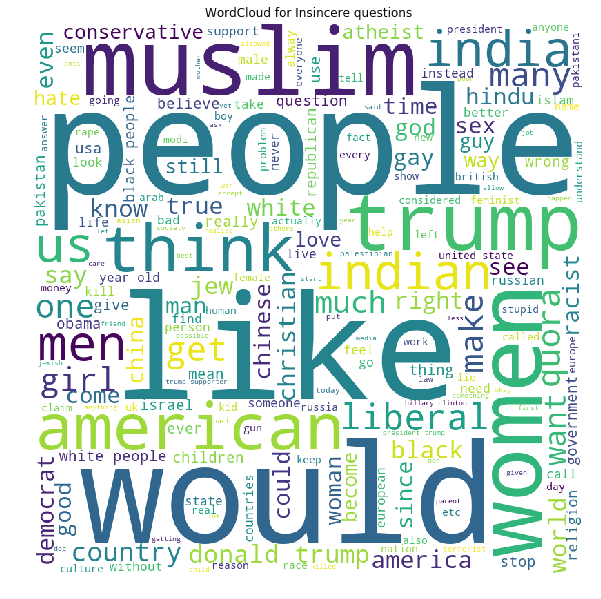

In [51]:
from wordcloud import WordCloud

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.title("WordCloud for Insincere questions")
plt.show()


1.From the WordCloud the words like Muslim,racist,american,Donald Trump,Indian,Pakistan,Gay,Christian and sex seems to be the most important words for declaring a question as an insincere question,Because if the question consists of any of these words than there is high probability of a question being insincere.

<h1>Getting the top 30 important words based on frequenices for Insincere questions</h1>

In [15]:
import pickle
quora_data=pickle.load(open('data.p','rb'))

In [2]:
quora_data.head()

,qid,question_text,target,Length,Total_Words,Total_stopwords,punctuations_count,uppercase_count,num_exclamation_marks,pre_essays
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,72,13,6,1,53,0,how quebec nationalists see province nation 1960s
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,81,16,8,2,63,0,do adopted dog would encourage people adopt no...
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,67,10,1,2,54,0,why velocity affect time does velocity affect ...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,57,9,2,1,44,0,how otto von guericke used magdeburg hemispheres
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,77,15,5,1,59,0,can i convert montra helicon d mountain bike c...


In [3]:
data_insincere=quora_data.loc[quora_data['target']==1] #Insincere questions

In [4]:
#Getting the top 50 words for insincere questions
from sklearn.feature_extraction.text import CountVectorizer

vec=CountVectorizer(lowercase=True,ngram_range=(1,1))
x=vec.fit_transform(data_insincere['pre_essays'].values)

In [51]:
word_frequencies=x.toarray().sum(axis=0)
words=vec.get_feature_names()
my_dict={}
for word,freq in zip(words,word_frequencies):
    my_dict[word]=freq

In [52]:
#printing the top 30 words for insincere questions
from collections import Counter
c=Counter(my_dict)
print(c.most_common(30))

[('why', 33047), ('not', 15310), ('people', 12980), ('is', 8891), ('how', 7569), ('trump', 6598), ('what', 6553), ('like', 6013), ('women', 6013), ('do', 5985), ('are', 4749), ('would', 4418), ('men', 4253), ('think', 3893), ('white', 3883), ('if', 3737), ('muslims', 3598), ('many', 3576), ('quora', 3424), ('india', 3324), ('get', 3238), ('indian', 3174), ('black', 3023), ('americans', 3021), ('us', 2918), ('sex', 2613), ('girls', 2539), ('indians', 2527), ('world', 2482), ('want', 2420)]


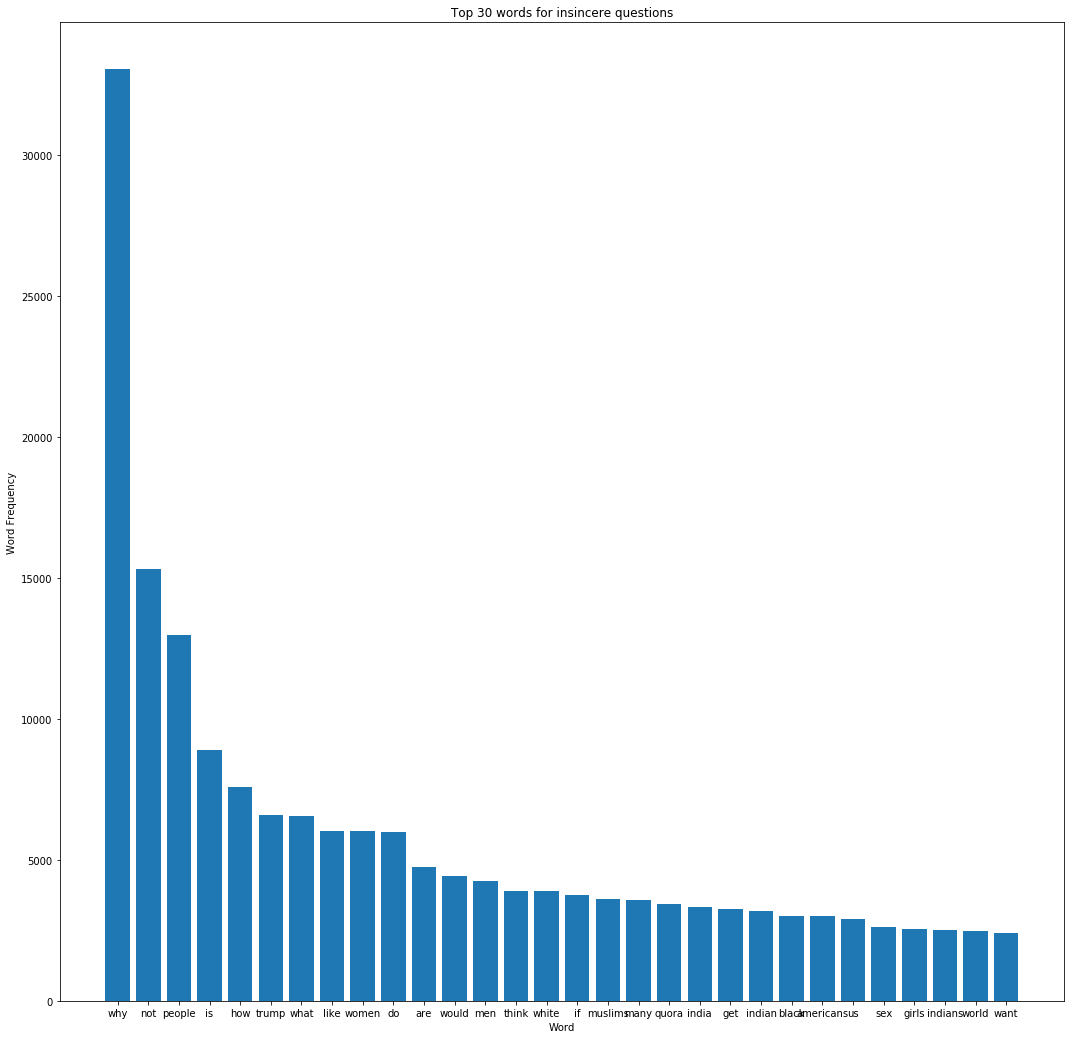

In [57]:
#Bar plot for the most common 30 words for insincere questions
top_words=[]
top_freq=[]
for word in (c.most_common(30)):
    top_words.append(word[0])
    top_freq.append(word[1])

plt.figure(figsize=(18,18))
plt.bar(top_words, top_freq)
plt.xlabel('Word', fontsize=10)
plt.ylabel('Word Frequency', fontsize=10)

plt.title('Top 30 words for insincere questions')
plt.show()

In [8]:
insincere_questions=quora_data.loc[quora_data['target']==1]

In [37]:
#Analyzing some insincere questions
print(insincere_questions.question_text.iloc[10])
print("="*50)

print(insincere_questions.question_text.iloc[25])
print("="*50)

print(insincere_questions.question_text.iloc[35])
print("="*50)

print(insincere_questions.question_text.iloc[53])
print("="*50)

print(insincere_questions.question_text.iloc[41])
print("="*50)

print(insincere_questions.question_text.iloc[79])
print("="*50)

print(insincere_questions.question_text.iloc[99])
print("="*50)


Would Europeans continue to participate in the Arab war for the destruction of Israel and killing all the Jews, if they knew that god himself defends Israel and he will do to Europeans what the Arabs want to do to the Jews?
How peoples in India seems hypocritical about womans empowerment?
Why do Americans need the second amendment? Don't want to start a fight but the right says it is necessary for a democracy and such and why are they so worried about the government.
Is there a spell in the Harry Potter universe to castrate your enemies?
How do I sell Pakistan? I need lots of money so I decided to sell Pakistan any one wanna buy?
Is Dalit girl faces more challenges then oher girls?
Why do psychopaths rape animals?


In [2]:
bad_words=['sex','sexual','ass','penis','cock','vagina','intercourse','fuck','intimacy','intimate','orgasm',
           'penetration','orgasm','threesome','romp','potency','cybersex','climax','buggery','cottaging','ejaculation',
            'favours','gang-bang','coitus','blow-job','sodomy','lovemaking','gay','sexy','vulgar','dick','di**','d**k','penises',
            'prostitute','masturbation']

In [4]:
quora_data['bad_words_count']=quora_data['question_text'].apply(lambda x:len([ch for ch in x.split() if ch in bad_words]))

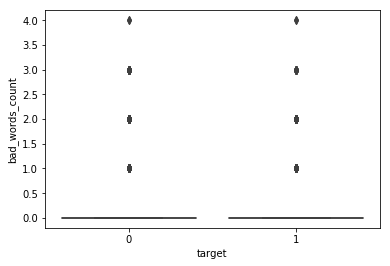

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.boxplot(y='bad_words_count',x='target',data=quora_data)
plt.show()

In [38]:
insincere_questions.head()

,qid,question_text,target,Length,Total_Words,Total_stopwords,punctuations_count,uppercase_count,num_exclamation_marks,pre_essays,bad_words_count
22,0000e91571b60c2fb487,Has the United States become the largest dicta...,1,67,11,4,1,53,0,has united states become largest dictatorship ...,0
30,00013ceca3f624b09f42,Which babies are more sweeter to their parents...,1,86,15,5,2,68,0,which babies sweeter parents dark skin babies ...,0
110,0004a7fcb2bf73076489,If blacks support school choice and mandatory ...,1,102,15,5,2,84,0,if blacks support school choice mandatory sent...,0
114,00052793eaa287aff1e1,I am gay boy and I love my cousin (boy). He is...,1,137,34,12,10,86,0,i gay boy i love cousin boy he sexy i dont kno...,0
115,000537213b01fd77b58a,Which races have the smallest penis?,1,36,6,2,1,29,0,which races smallest penis,0


In [7]:
#Applying Lemmatization
lem = WordNetLemmatizer()
def clean_Question(question):
    words = [lem.lemmatize(word, "v") for word in question.split(" ")]
    clean_sent=" ".join(words)
    return clean_sent

In [ ]:
quora_data['preprocessed_questions']=quora_data['pre_essays'].apply(lambda q:clean_Question(q))

In [13]:
quora_data.head()

,qid,question_text,target,Length,Total_Words,Total_stopwords,punctuations_count,uppercase_count,num_exclamation_marks,preprocessed_questions
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0,72,13,6,1,53,0,how quebec nationalists see province nation 1960s
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0,81,16,8,2,63,0,do adopt dog would encourage people adopt not ...
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0,67,10,1,2,54,0,why velocity affect time do velocity affect sp...
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0,57,9,2,1,44,0,how otto von guericke use magdeburg hemispheres
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0,77,15,5,1,59,0,can i convert montra helicon d mountain bike c...


In [12]:
import pickle
pickle.dump(quora_data,open('final_data.p','wb'))

In [23]:
from textblob import TextBlob
from tqdm import tqdm

pos_tags=[]
for question in tqdm(quora_data['preprocessed_questions'].values):
    text=TextBlob(question)
    pos_tags.append(text.tags)

100%|███████████████████████████████████████████████████████████████████████| 1306122/1306122 [53:24<00:00, 407.53it/s]


In [24]:
pickle.dump(pos_tags,open('pos_tags.p','wb'))

In [44]:
#Loading the tags file
pos_tags=pickle.load(open('pos_tags.p','rb'))

<h1>Named Entity Recognition on Insincere Questions</h1>

In [55]:
#Collecting all insicnere questions
insincere_questions=quora_data.loc[quora_data['target']==1]

In [57]:
#Printing the POS tags for a random question
pos_tags[100]

[('what', 'WP'),
 ('physicists', 'VBZ'),
 ('mathematicians', 'NNS'),
 ('computer', 'NN'),
 ('scientists', 'NNS'),
 ('philosophers', 'NNS'),
 ('think', 'VBP'),
 ('david', 'JJ'),
 ('deutsch', 'NN'),
 ('constructor', 'NN'),
 ('theory', 'NN')]

In [64]:
#Selecting tags for insincere questions
insincere_questions_indices=quora_data.loc[quora_data['target']==1].index.tolist()
insincere_tags=[pos_tags[i] for i in insincere_questions_indices]

In [ ]:
insincere_tags_df=pd.DataFrame()
for tags in tqdm(insincere_tags):
    temp=pd.DataFrame(data=tags,columns=['Word','POS'])
    insincere_tags_df=pd.concat([insincere_tags_df,temp])

In [69]:
pickle.dump(insincere_tags_df,open('Insincere_Questions_tags_df','wb'))

In [3]:
import pickle
insincere_tags_df=pickle.load(open('Insincere_Questions_tags_df','rb'))

In [4]:
insin_tags_grp=insincere_tags_df.groupby('POS')
insin_tag={}
for i,j in insin_tags_grp:
    insin_tag[i]=j.shape[0]

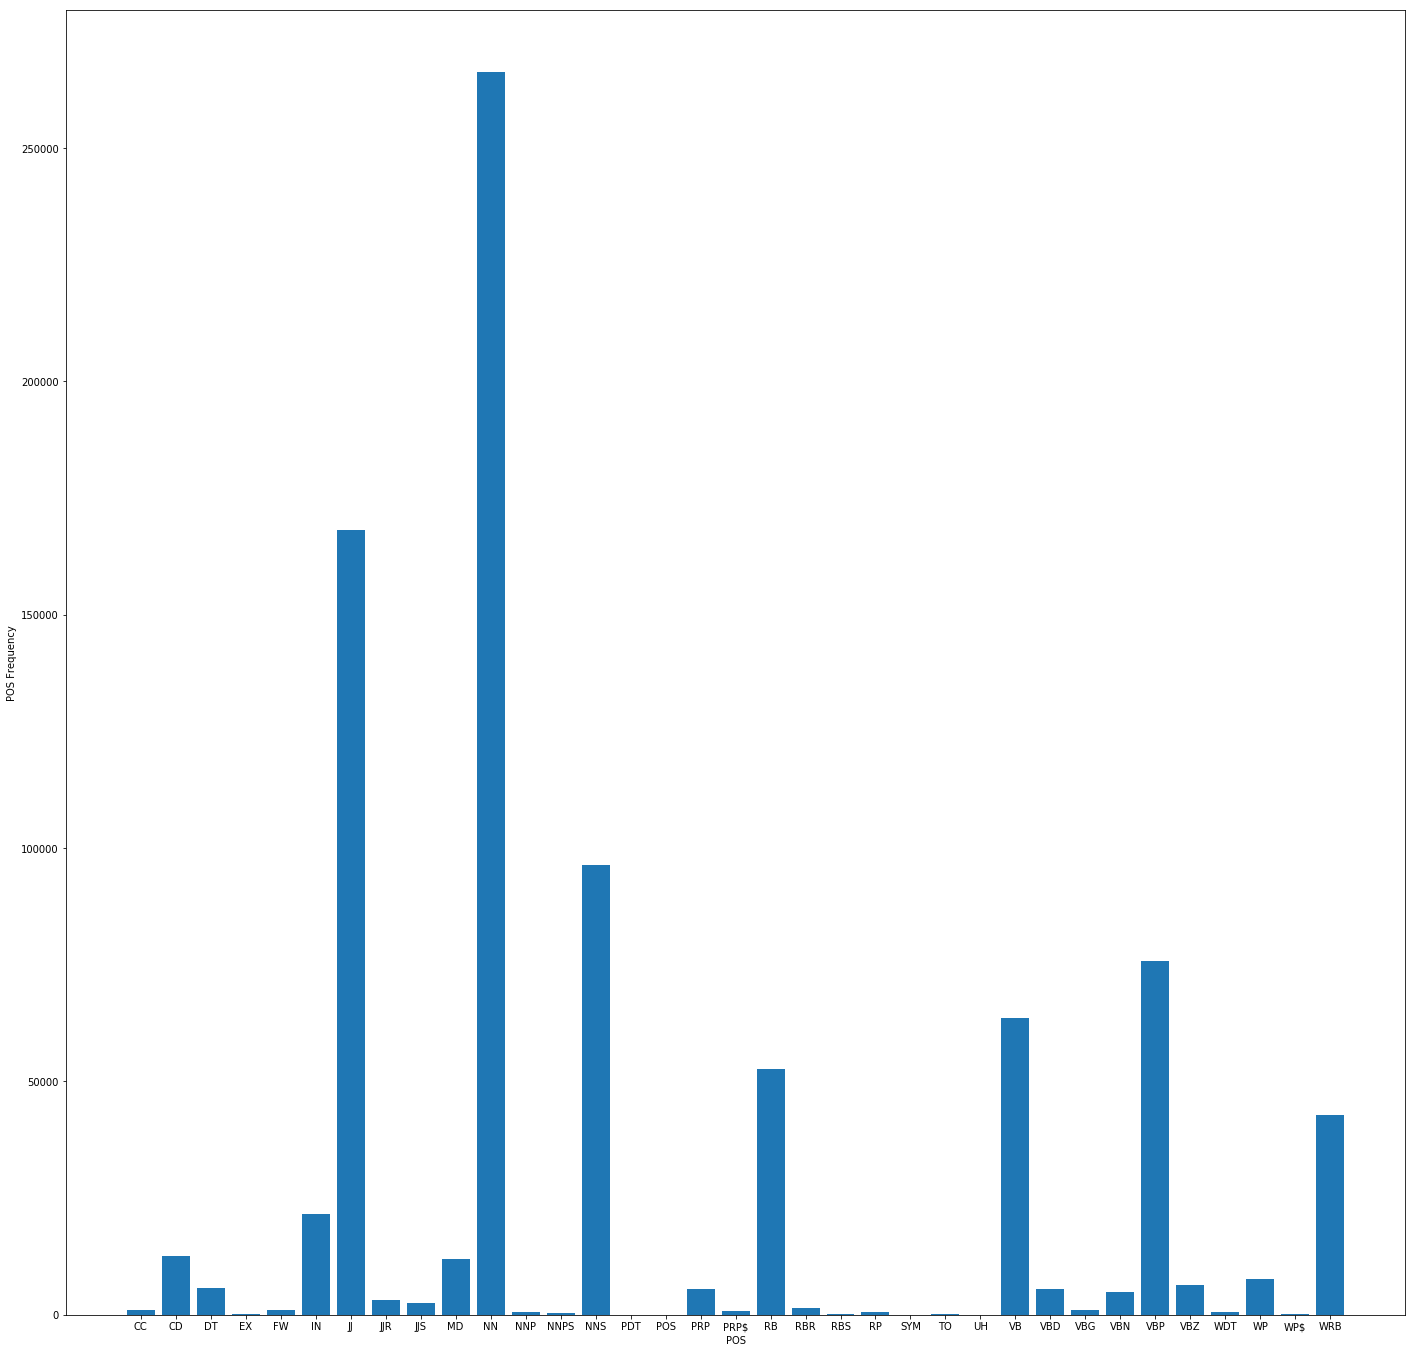

In [81]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24,24))
plt.bar(insin_tag.keys(), insin_tag.values())
plt.xlabel('POS', fontsize=10)
plt.ylabel('POS Frequency', fontsize=10)
plt.show()

In [8]:
#Summing up all nouns 
total_nouns=insin_tag['NN']+insin_tag['NNP']+insin_tag['NNPS']+insin_tag['NNS']
print("Percentage of words with Nouns are {0}".format((total_nouns/len(insincere_tags_df))*100))

Percentage of words with Nouns are 42.20477375998885


In [10]:
#Summing up all the verbs
total_verbs=insin_tag['VBD']+insin_tag['VBG']+insin_tag['VBN']+insin_tag['VBP']
print("Percentage of words with Verbs are {0}".format((total_verbs/len(insincere_tags_df))*100))

Percentage of words with Verbs are 10.137595245971088


In [11]:
#Summing up all the adverbs
total_adverbs=insin_tag['RBR']+insin_tag['RBS']+insin_tag['RB']
print("Percentage of words with Adverbs are {0}".format((total_verbs/len(insincere_tags_df))*100))

Percentage of words with Adverbs are 10.137595245971088


<h1>Named Entity Recognition on Sincere Questions</h1>

In [82]:
#Selecting Tags of Sincere Questions
sincere_questions_indices=quora_data.loc[quora_data['target']==0].index.tolist()
sincere_tags=[pos_tags[i] for i in sincere_questions_indices]

In [ ]:
#Creating Dataframe having coluns as word and the part of speech associated with that word
from tqdm import tqdm
sincere_tags_df=pd.DataFrame()
for tags in tqdm(sincere_tags):
    temp=pd.DataFrame(data=tags,columns=['Word','POS'])
    sincere_tags_df=pd.concat([sincere_tags_df,temp])

In [97]:
tags_len_computed=len(sincere_tags_df)

In [98]:
#Creating Dictionary of POS and its count
pos_group_sincere=sincere_tags_df.groupby('POS')
dict_sincere_pos={}

for i,j in pos_group_sincere:
    dict_sincere_pos[i]=j.shape[0]

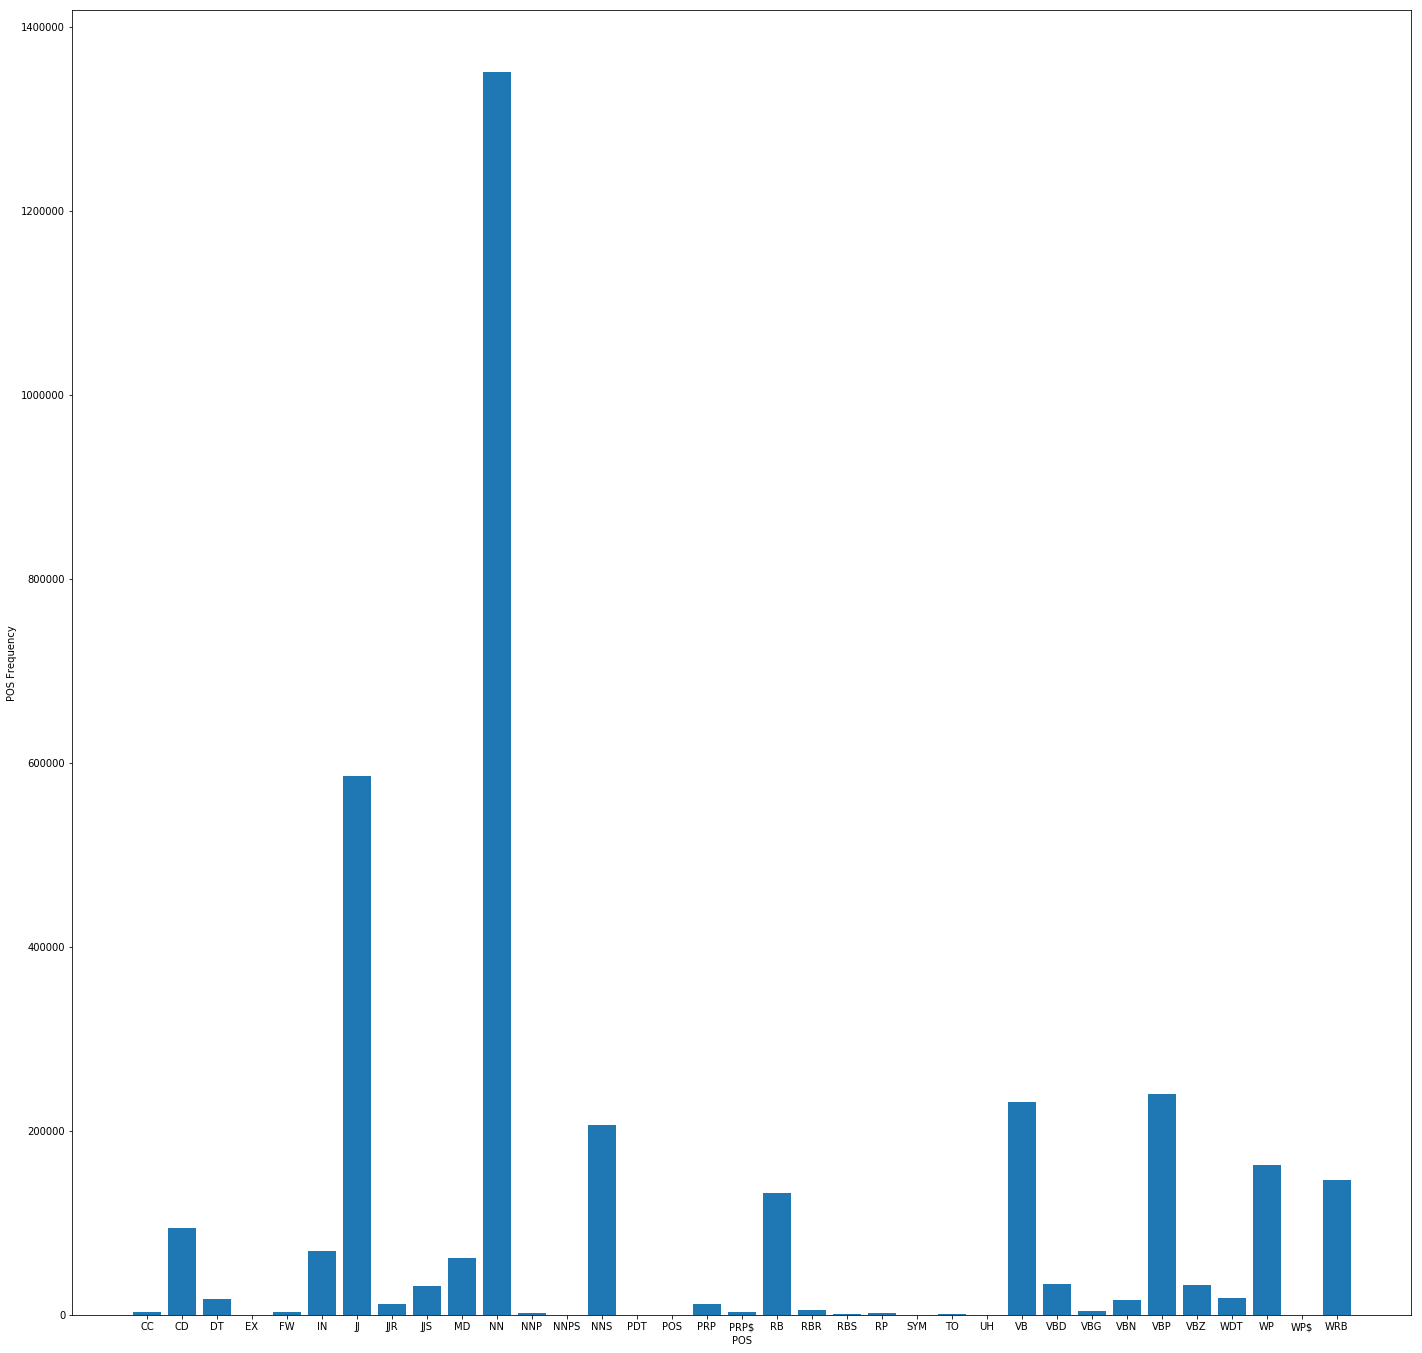

In [99]:
import matplotlib.pyplot as plt

plt.figure(figsize=(24,24))
plt.bar(dict_sincere_pos.keys(), dict_sincere_pos.values())
plt.xlabel('POS', fontsize=10)
plt.ylabel('POS Frequency', fontsize=10)
plt.show()

In [17]:
import pickle
quora_data=pickle.load(open('final_data.p','rb'))

In [ ]:
quora_data.head()

In [32]:
quora_data['num_unique_words'] = quora_data['question_text'].apply(
    lambda question: len(set(w for w in question.split())))

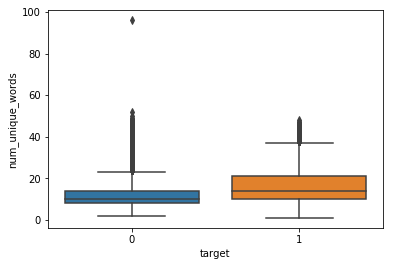

In [34]:
sns.boxplot(y='num_unique_words',x='target',data=quora_data)
plt.show()

1.Number of Unique words for InSincere Questions are more as compared to Sincere Questions

C:\Users\om\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\om\Anaconda31\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\om\Anaconda31\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


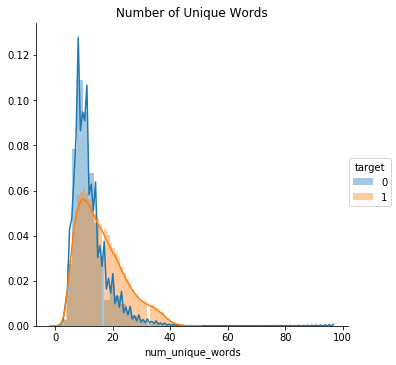

In [38]:
sns.FacetGrid(quora_data,hue='target',size=5)\
             .map(sns.distplot,"num_unique_words")\
             .add_legend()
plt.title("Number of Unique Words")
plt.show()

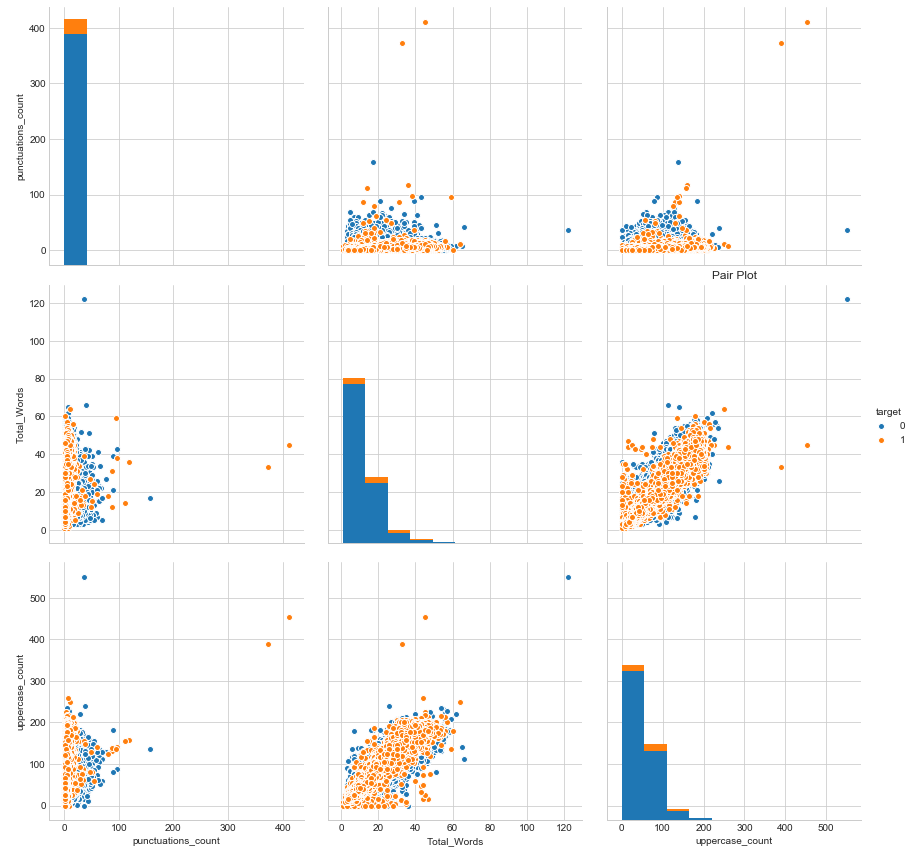

In [44]:
sns.set_style("whitegrid")
sns.pairplot(quora_data,hue='target',vars=["punctuations_count","Total_Words","uppercase_count"],size=4)
plt.title("Pair Plot")
plt.show()

In [36]:
quora_data['words_vs_unique'] = quora_data['num_unique_words'] / quora_data['Total_Words']

C:\Users\om\Anaconda31\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\om\Anaconda31\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\om\Anaconda31\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


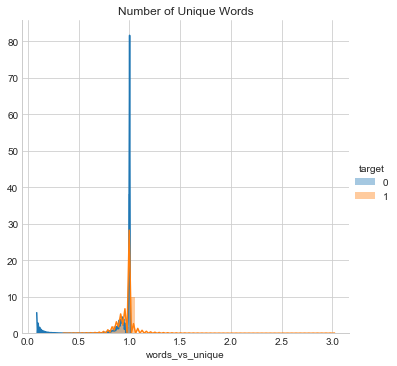

In [45]:
sns.FacetGrid(quora_data,hue='target',size=5)\
             .map(sns.distplot,"words_vs_unique")\
             .add_legend()
plt.title("Number of Unique Words")
plt.show()